## Georegistering Images without Keypoints or GCPs

This code attempts to georegister based entirely on IMU, GPS information. Assuming the lat, lon, altitude, yaw, pitch, and roll information is correct it warps and reprojects the image to how it would'be appeared on Earth.

One major assumption is that the imagery is totally flat so this is most useful for ocean color images.

In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import geopandas as gpd
import pandas as pd

import os, glob, math, datetime
import multiprocessing

import cv2
import numpy as np
import matplotlib.pyplot as plt

import exiftool

import rasterio
import micasense.image as image

### Get all the metadata

In this case I pull it from both the image metadata and from the aircraft flight logs

Image we want to warp and georeg

In [275]:
path_name = 'data/20210304_duml_newgimbal_mapping_testing/sea/IMG_0097_4.tif'

Worth noting that this Micasense [notebook](https://github.com/micasense/imageprocessing/blob/e3744671c521056de46c3d05c3e9446a971662c9/MicaSense%20Image%20Processing%20Tutorial%203.ipynb) has this caveat about the sensor:
        
>An onboard orientation sensor provides a fairly rough version of the earth-fixed orientation of the DLS. The quality of this orientation varies based on the quality of the sensor installation and calibration, but in even the best cases it has a few degrees of error.

Thus in this example I'm using the aircraft flight logs for orientation data in the actual final function.

In [5]:
path_name

'data/20210304_duml_newgimbal_mapping_testing/sea/IMG_0097_4.tif'

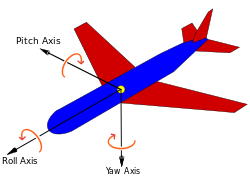

In [11]:
sensor_offset = 40 # this is the difference of the sensor and the DLS on our aircraft

### Define the cameras parameters

These can either come from a spec document and be manually updated or pulled from the sensor class as in this case with Micasense

In [26]:
# intrinsic camera parameters
f = img.focal_length # returns focal length in mm
# dividing the pixel size by the focal plane resolution in mm to get sensor size - px/(px/mm) leaves mm
sensor_size = img.size()[0] / img.focal_plane_resolution_px_per_mm[0], img.size()[1] / img.focal_plane_resolution_px_per_mm[1]    # in mm
image_size = img.size()    # in px

f, sensor_size, image_size

(7.821876914999999, (7.12080001139328, 5.32680000852288), (2064, 1544))

### Define the location and pose information

If using the data from the Micasense images you can use:

In [280]:
img = image.Image(path_name)

# this fcn returns (yaw,pitch,roll) tuples in radians of the earth-fixed dls pose
yaw, pitch, roll = np.array([img.dls_yaw, img.dls_pitch, img.dls_roll]) * 180/math.pi # convert this to degrees for cameratransform
alt, lat, lon = img.altitude, img.latitude, img.longitude

yaw, pitch, roll, alt, lat, lon 

(-59.682464952096794,
 -3.388516593867085,
 9.36181782005857,
 46.298,
 34.7155427,
 -76.672801)

The location information from the Alta is much better for both GPS and yaw than the Micasense Altum. We also use a gimbal to keep the pitch and roll stable so those are static values.

In [224]:
alta_logs = pd.read_csv('data/20210304_duml_newgimbal_mapping_testing/SYNLog-16-17-34_04-03-2021_edit.csv')
print(len(alta_logs), 'rows')
alta_logs.head()

41994 rows


/home/clifgray/anaconda3/envs/micasense_ocean_color/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (0,1,2,4,5,6,7,9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Reading,IMU Time,Date,GPS Time,Unnamed: 4,Longitude,Latitude,GPS Height,GPS Course,GPS Pos N,...,Gyro Bias R,Gyro Bias P,Gyro Bias Y,Accel Bias X,Accel Bias Y,Accel Bias Z,Extended Status,5V Alarm,Z Vibration,Checksum
0,26,0.976,20210304,16:17:34,NaN,-766727168,347156224,-0.3,22.8,-1.26,...,11.3907,-33.8277,6.4131,0.0,0.0,0.246,0.0,0.0,0.03,54.0
1,28,1.056,20210304,16:17:34,NaN,-766727168,347156224,-0.3,22.8,-1.26,...,11.3907,-33.8290,6.4075,0.0,0.0,0.246,0.0,0.0,0.03,249.0
2,29,1.096,20210304,16:17:34,NaN,-766727168,347156224,-0.3,22.8,-1.26,...,11.3901,-33.8293,6.4075,-0.0,-0.0,0.246,0.0,0.0,0.03,28.0
3,30,1.136,20210304,16:17:34,NaN,-766727168,347156224,-0.3,22.8,-1.26,...,11.3899,-33.8297,6.4073,-0.0,-0.0,0.246,0.0,0.0,0.03,107.0
4,31,1.176,20210304,16:17:35,NaN,-766727168,347156256,-0.3,22.8,-1.25,...,11.3899,-33.8309,6.4074,-0.0,-0.0,0.246,0.0,0.0,0.03,252.0


The last few hundred rows are summary data and don't follow the format for the csv

In [225]:
alta_logs.drop(alta_logs.tail(250).index,inplace=True)

#### Create a datetime column, then make it the index, and then find the closest row to the image time

This one may introduce a tiny bit of error, it creates a DateTime index but it isn't precise enough so I add on the ID field as milliseconds to ensure they're in the correct order

In [229]:
alta_logs['id'] = alta_logs.index

In [233]:
alta_logs['dt'] = pd.to_datetime(alta_logs.Date.apply(str)+alta_logs['GPS Time']+'.'+alta_logs.id.apply(str).str.zfill(9).apply(str).str.slice(start=3,stop=9), format='%Y%m%d%H:%M:%S.%f')

In [234]:
alta_logs = alta_logs.set_index('dt')

In [281]:
alta_logs.head(1)

,Reading,IMU Time,Date,GPS Time,Unnamed: 4,Longitude,Latitude,GPS Height,GPS Course,GPS Pos N,...,Gyro Bias P,Gyro Bias Y,Accel Bias X,Accel Bias Y,Accel Bias Z,Extended Status,5V Alarm,Z Vibration,Checksum,id
dt,,,,,,,,,,,,,,,,,,,,,
2021-03-04 16:17:34,26,0.976,20210304,16:17:34,NaN,-766727168,347156224,-0.3,22.8,-1.26,...,-33.8277,6.4131,0.0,0.0,0.246,0.0,0.0,0.03,54.0,0


Now find the closest entry

In [285]:
img_idx = alta_logs.index.get_loc(img.utc_time, method='nearest')

In [286]:
lat = float(str(alta_logs.iloc[img_idx]['Latitude'])[:2] + '.' + str(alta_logs.iloc[img_idx]['Latitude'])[2:])
lon = float(str(alta_logs.iloc[img_idx]['Latitude'])[:2] + '.' + str(alta_logs.iloc[img_idx]['Latitude'])[2:])
alt = alta_logs.iloc[img_idx]['GPS Height']
yaw = alta_logs.iloc[img_idx]['Yaw']

### Now create the camera transform

In [287]:
import cameratransform as ct

cam = ct.Camera(ct.RectilinearProjection(focallength_mm=f,
                                         sensor=sensor_size,
                                         image=image_size),
               ct.SpatialOrientation(elevation_m=alt, # img.altitude,
                                     tilt_deg=40,
                                     roll_deg=0,
                                    heading_deg=yaw,
                                    pos_x_m=0, pos_y_m=0))

# gps pts are lat lon
cam.setGPSpos(lat, lon, alt)

Convert from space to top down image pixel location

In [258]:
# space location / scaling factor - half the image

def spacetotopdown(top_im, cam, image_size, scaling):
    x1 = top_im.shape[0]/2 + cam.spaceFromImage([0,0])[0] / scaling
    y1 = top_im.shape[1]/2 - cam.spaceFromImage([0,0])[1] / scaling
    
    x2 = top_im.shape[0]/2 + cam.spaceFromImage([image_size[0]-1,0])[0] / scaling
    y2 = top_im.shape[1]/2 - cam.spaceFromImage([image_size[0]-1,0])[1] / scaling
    
    x3 = top_im.shape[0]/2 + cam.spaceFromImage([image_size[0]-1,image_size[1]-1])[0] / scaling
    y3 = top_im.shape[1]/2 - cam.spaceFromImage([image_size[0]-1,image_size[1]-1])[1] / scaling
    
    x4 = top_im.shape[0]/2 + cam.spaceFromImage([0,image_size[1]-1])[0] / scaling
    y4 = top_im.shape[1]/2 - cam.spaceFromImage([0,image_size[1]-1])[1] / scaling
    return(np.array([[x1,y1], [x2,y2], [x3,y3], [x4,y4]]))
    #return([x1,x2,x3,x4],[y1, y2, y3,y4])

Inspect this image

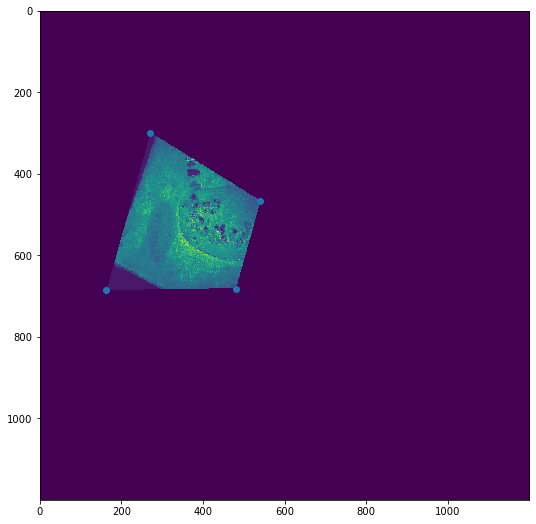

In [290]:
fig,ax = plt.subplots(figsize=(9,9))
scaling = .2
im = plt.imread(path_name)
# this 120 value is approximate and based on altitude, FOV, and viewing geometry
top_im = cam.getTopViewOfImage(im, [-120, 120,-120, 120], scaling=scaling, do_plot=False)

# Now get the image coordinates of the corners of the original image but in the top down image
image_coords = spacetotopdown(top_im, cam, image_size, scaling)

# show this image
ax.imshow(top_im, interpolation='none', vmin=0, vmax=65000)
# ax.set_xlabel("x position in m")
# ax.set_ylabel("y position in m");
ax.scatter(image_coords[:,0],image_coords[:,1])

Use the cameratransform package to get the geographic coordinates of the image

In [263]:
coords = np.array([
    cam.gpsFromImage([0               , 0]), \
    cam.gpsFromImage([image_size[0]-1 , 0]), \
    cam.gpsFromImage([image_size[0]-1 , image_size[1]-1]), \
    cam.gpsFromImage([0               , image_size[1]-1])])

Convert all that to GCPs for `rasterio`

In [291]:
gcp1 = rasterio.control.GroundControlPoint(row=image_coords[0,0], col=image_coords[0,1], x=coords[0,1], y=coords[0,0], z=coords[0,2], id=None, info=None)
gcp2 = rasterio.control.GroundControlPoint(row=image_coords[1,0], col=image_coords[1,1], x=coords[1,1], y=coords[1,0], z=coords[1,2], id=None, info=None)
gcp3 = rasterio.control.GroundControlPoint(row=image_coords[2,0], col=image_coords[2,1], x=coords[2,1], y=coords[2,0], z=coords[2,2], id=None, info=None)
gcp4 = rasterio.control.GroundControlPoint(row=image_coords[3,0], col=image_coords[3,1], x=coords[3,1], y=coords[3,0], z=coords[3,2], id=None, info=None)

In [292]:
[gcp1,gcp2,gcp3,gcp4]

[GroundControlPoint(row=162.92674802728203, col=686.0333234349586, x=34.71458922358496, y=34.71539085418051, z=-7.105427357601002e-15, id='2bd204e2-402c-49b7-ada0-1c6aa4f9a785'),
 GroundControlPoint(row=270.65852550639073, col=300.18145470675915, x=34.714824949489824, y=34.71608486039159, z=-7.105427357601002e-15, id='e51bc71e-f316-4613-8db9-1c4f84d4cea1'),
 GroundControlPoint(row=539.8357060555867, col=467.6893147685623, x=34.71541395162127, y=34.71578357784536, z=0.0, id='f80e55d9-eb87-4707-b886-1adaafcb7f89'),
 GroundControlPoint(row=479.9680849532999, col=682.1110389725345, x=34.7152829536315, y=34.715397912372204, z=0.0, id='b291c776-62e3-4059-a1f6-56d0869f72bb')]

Use those GCPs to georeference the image

In [300]:
import rasterio
from rasterio.warp import reproject
from rasterio.enums import Resampling

# Register GDAL format drivers and configuration options with a
# context manager.
with rasterio.Env():
    
    # open the original image to get some of the basic metadata
    with rasterio.open(path_name, 'r') as src:
        profile = src.profile
        print('initial profile')
        print(profile)
                
        src_crs = "EPSG:4326"  # This is the crs of the GCPs
        dst_crs = "EPSG:4326"

        tsfm = rasterio.transform.from_gcps([gcp1,gcp2,gcp3,gcp4])
        profile.update(
            dtype=rasterio.float32,
            transform = tsfm,
            crs=dst_crs,
            width=top_im.shape[0], # TODO unsure if this is correct order
            height=top_im.shape[1]
        )
        
        print('updated profile')
        print(profile)
        new_fn = path_name.split('/')[-1].split('.')[0]+'_georeferenced.tif'
        print(new_fn)
        with rasterio.open(new_fn, 'w', **profile) as dst:
            # we then need to transpose it because it gets flipped compared to expected output
            dst.write(top_im.T.astype(rasterio.float32), 1)

initial profile
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 2064, 'height': 1544, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False, 'interleave': 'band'}
updated profile
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1200, 'height': 1200, 'count': 1, 'crs': 'EPSG:4326', 'transform': Affine(1.4111421741988557e-11, 2.18814287050064e-06, 34.71423270631643,
       -1.7986303593870601e-06, 9.600663048236924e-12, 34.71662477312512), 'tiled': False, 'interleave': 'band'}
IMG_0097_4_georeferenced.tif


In [ ]:
rasterio.float32

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1200, 'height': 1200, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(1.4111421741988557e-11, 2.18814287050064e-06, 34.71423270631643,
       -1.7986303593870601e-06, 9.600663048236924e-12, 34.71662477312512)}


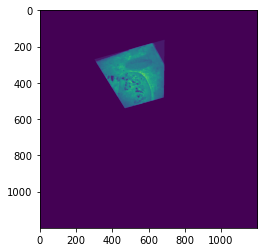

In [302]:
with rasterio.open('IMG_0097_4_georeferenced.tif') as source:
    print(source.read(1))
    plt.imshow(source.read(1), vmin=0, vmax=65000)
    print(source.meta)

### Now actual operational functions for this

In [377]:
def georegister_drone_imgs(path_name, lat, lon, alt, yaw, roll, pitch, focal_length, 
                           sensor_size, image_size, scaling=0.2, top_im_size=120, visualize=True):
    cam = ct.Camera(
        ct.RectilinearProjection(focallength_mm=focal_length,
                sensor=sensor_size,
                image=image_size),
            ct.SpatialOrientation(elevation_m=alt, # img.altitude,
                    tilt_deg=pitch,
                    roll_deg=roll,
                    heading_deg=yaw,
                    pos_x_m=0, pos_y_m=0)
    )

    # gps pts are lat lon
    cam.setGPSpos(lat, lon, alt)
    
    im = plt.imread(path_name)
    # this value is approximate and based on altitude, FOV, and viewing geometry
    top_im = cam.getTopViewOfImage(im, [-top_im_size, top_im_size,-top_im_size, top_im_size], scaling=scaling, do_plot=False)
    image_coords = spacetotopdown(top_im, cam, image_size, scaling)
    
    if visualize:
        fig,ax = plt.subplots(figsize=(9,9))
        ax.imshow(top_im, interpolation='none', vmin=0, vmax=65000)
        # ax.set_xlabel("x position in m")
        # ax.set_ylabel("y position in m");
        ax.scatter(image_coords[:,0],image_coords[:,1])
        fig.show()
        
    
    coords = np.array([
        cam.gpsFromImage([0               , 0]), \
        cam.gpsFromImage([image_size[0]-1 , 0]), \
        cam.gpsFromImage([image_size[0]-1 , image_size[1]-1]), \
        cam.gpsFromImage([0               , image_size[1]-1])]
    )
    
    gcp1 = rasterio.control.GroundControlPoint(row=image_coords[0,0], col=image_coords[0,1], x=coords[0,1], y=coords[0,0], z=coords[0,2], id=None, info=None)
    gcp2 = rasterio.control.GroundControlPoint(row=image_coords[1,0], col=image_coords[1,1], x=coords[1,1], y=coords[1,0], z=coords[1,2], id=None, info=None)
    gcp3 = rasterio.control.GroundControlPoint(row=image_coords[2,0], col=image_coords[2,1], x=coords[2,1], y=coords[2,0], z=coords[2,2], id=None, info=None)
    gcp4 = rasterio.control.GroundControlPoint(row=image_coords[3,0], col=image_coords[3,1], x=coords[3,1], y=coords[3,0], z=coords[3,2], id=None, info=None)
    
    
    # Register GDAL format drivers and configuration options with a
    # context manager.
    with rasterio.Env():
        # open the original image to get some of the basic metadata
        with rasterio.open(path_name, 'r') as src:
            profile = src.profile
            print('initial profile')
            print(profile)

            src_crs = "EPSG:4326"  # This is the crs of the GCPs
            dst_crs = "EPSG:4326"

            tsfm = rasterio.transform.from_gcps([gcp1,gcp2,gcp3,gcp4])
            profile.update(
                dtype=rasterio.float32,
                transform = tsfm,
                crs=dst_crs,
                width=top_im.shape[0], # TODO unsure if this is correct order
                height=top_im.shape[1]
            )

            print('updated profile')
            print(profile)
            new_fn = path_name.split('/')[-1].split('.')[0]+'_georeferenced.tif'
            with rasterio.open(new_fn, 'w', **profile) as dst:
                # we then need to transpose it because it gets flipped compared to expected output
                # TODO could and shout probably convert this back to an int
                dst.write(top_im.T.astype(rasterio.float32), 1)
                print('written out as ', new_fn)
                
    return(True)

In [378]:
def format_alta_logs(fp):
    alta_logs = pd.read_csv(fp)
    # the last few hundred lines don't follow csv rules and are just summary data
    alta_logs.drop(alta_logs.tail(250).index,inplace=True)
    # this may introduce a tiny bit of error but I do this so I have a unique index for matching time
    # TODO could instead resample to seconds and take a mean
    alta_logs['id'] = alta_logs.index
    alta_logs['dt'] = pd.to_datetime(alta_logs.Date.apply(str)+alta_logs['GPS Time']+'.'+alta_logs.id.apply(str).str.zfill(9).apply(str).str.slice(start=3,stop=9), format='%Y%m%d%H:%M:%S.%f')
    alta_logs = alta_logs.set_index('dt')
    return(alta_logs)


In [379]:
# TODO change it to this
# alta_micasense_georef(img_info_path_name, data_path_name, alta_logs, scaling=0.1, top_im_size=120):
def alta_micasense_georef(path_name, alta_logs, scaling=0.1, top_im_size=120):
    # open up the micasense camera object
    img = image.Image(path_name)
    
    # define intrinsic camera parameters
    f = img.focal_length # returns focal length in mm
    # dividing the pixel size by the focal plane resolution in mm to get sensor size - px/(px/mm) leaves mm
    sensor_size = img.size()[0] / img.focal_plane_resolution_px_per_mm[0], img.size()[1] / img.focal_plane_resolution_px_per_mm[1]    # in mm
    image_size = img.size()    # in px    
    
    img_idx = alta_logs.index.get_loc(img.utc_time, method='nearest')
    lat = float(str(alta_logs.iloc[img_idx]['Latitude'])[:2] + '.' + str(alta_logs.iloc[img_idx]['Latitude'])[2:])
    # TODO this assumes it is always negative with :3. be better.
    lon = float(str(alta_logs.iloc[img_idx]['Longitude'])[:3] + '.' + str(alta_logs.iloc[img_idx]['Longitude'])[3:])
    alt = alta_logs.iloc[img_idx]['GPS Height']
    yaw = alta_logs.iloc[img_idx]['Yaw']
    roll = 0
    pitch = 40+4 # TODO could pull this off the gimbal if it logged it
    
    print(lat, lon, alt, yaw, roll, pitch)
    
    if georegister_drone_imgs(path_name, lat, lon, alt, yaw, roll, pitch, f, 
                           sensor_size, image_size, scaling=scaling, top_im_size=top_im_size, visualize=True):
        print('Complete!')

In reality I'll need both the micasense filepath AND the chla data and that will both go into this function and the actual data written will be the chla data

/home/clifgray/anaconda3/envs/micasense_ocean_color/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3347: DtypeWarning: Columns (0,1,2,4,5,6,7,9) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/clifgray/anaconda3/envs/micasense_ocean_color/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3427: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


34.7155456 -76.6728128 48.18 -74.4 0 44
initial profile
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 2064, 'height': 1544, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False, 'interleave': 'band'}
updated profile
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2400, 'height': 2400, 'count': 1, 'crs': 'EPSG:4326', 'transform': Affine(8.59464575060284e-12, 1.0940714799715657e-06, -76.67412569542374,
       -8.99315303727289e-07, 5.716736570358628e-12, 34.71662477246828), 'tiled': False, 'interleave': 'band'}
written out as  IMG_0097_1_georeferenced.tif
Complete!


/home/clifgray/anaconda3/envs/micasense_ocean_color/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/clifgray/anaconda3/envs/micasense_ocean_color/lib/python3.7/site-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


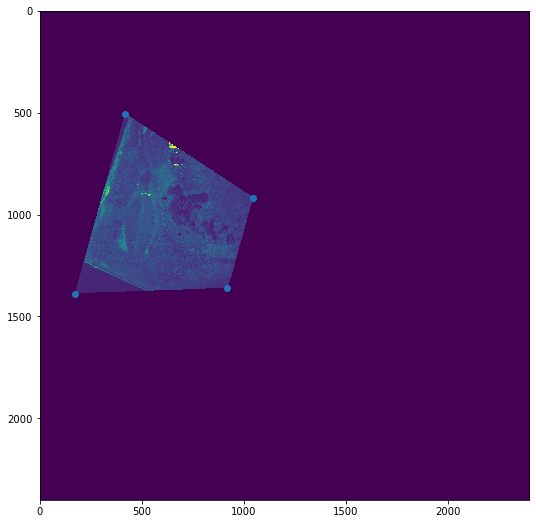

In [380]:
alta_logs = format_alta_logs('data/20210304_duml_newgimbal_mapping_testing/SYNLog-16-17-34_04-03-2021_edit.csv')

img_fp_list = ['data/20210304_duml_newgimbal_mapping_testing/sea/IMG_0097_1.tif']

for image_fp in img_fp_list:
    alta_micasense_georef(image_fp, alta_logs, scaling=0.1)